In [1]:
import json
from datetime import datetime
import warnings
from copy import deepcopy

import pandas as pd
import numpy as np
import SparseSC
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE

from synth_trainers import calculate_synths, calculate_synths_for_placebo
from vizualization_utils import vizualize_synth, vizualize_post_pre
from calc_utils import calculate_post_pre_mae_relations, try_calculate_p_values, NumpyEncoder

%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [2]:
df_ru = pd.read_csv('./datasets/df_ru.csv')
wiki_url = 'https://ru.wikipedia.org/wiki/%D0%9E%D1%81%D0%BE%D0%B1%D0%B0%D1%8F_%D1%8D%D0%BA%D0%BE%D0%BD%D0%BE%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%B7%D0%BE%D0%BD%D0%B0'
df_sez = pd.read_html(wiki_url)[2]
df_sez.columns = ['sez_name', 'region', 'date']

In [3]:
df_ru['region'] = df_ru['region'].str.rstrip().str.lower()
df_ru['unemployment'] = pd.to_numeric(df_ru['unemployment'], errors='coerce')
df_ru['fixed_assets'] = pd.to_numeric(df_ru['fixed_assets'], errors='coerce')
df_ru['grp'] = pd.to_numeric(df_ru['grp'], errors='coerce')
region_names_en = df_ru['region'].unique()

In [6]:
sezs_region_and_year = [
    ('republic of tatarstan', 2005),
    ('lipetsk region', 2006),
    ('samara region', 2010),
    ('sverdlovsk region', 2010),
    ('pskov region', 2012),
    ('kaluga region', 2012),
    ('astrakhan region', 2014),
    ('moscow region', 2015),
    ('tula region', 2016),
]

In [7]:
LIST_OF_REGIONS_WITH_SEZS = [x[0] for x in sezs_region_and_year]

In [9]:
#df_samara_only = df_ru[df_ru['region'] == 'samara region']
df_grp = df_ru[['region', 'year', 'grp']]
df_grp = df_grp.pivot(index= 'region', columns = 'year', values = "grp")
df_population = df_ru[['region', 'year', 'population']]
df_population = df_population.pivot(index= 'region', columns = 'year', values = "population")
df_industry = df_ru[['region', 'year', 'industry_production']]
df_industry = df_industry.pivot(index= 'region', columns = 'year', values = "industry_production")
df_export = df_ru[['region', 'year', 'export']]
df_export = df_export.pivot(index= 'region', columns = 'year', values = "export")
df_price_indexes = df_ru[['region', 'year', 'price_indexes']]
df_price_indexes = df_price_indexes.pivot(index= 'region', columns = 'year', values = "price_indexes")
df_unemployment = df_ru[['region', 'year', 'unemployment']]
df_unemployment = df_unemployment.pivot(index= 'region', columns = 'year', values = "unemployment")
df_investments = df_ru[['region', 'year', 'investments']]
df_investments = df_investments.pivot(index= 'region', columns = 'year', values = "investments")
df_fixed_assets = df_ru[['region', 'year', 'fixed_assets']]
df_fixed_assets = df_fixed_assets.pivot(index= 'region', columns = 'year', values = "fixed_assets")

DATAFRAMES = {
    'grp': df_grp, 
    'industry': df_industry, 
    'investments': df_investments, 
    'fixed_assets': df_fixed_assets
}

In [10]:
for df in [df_grp, df_industry, df_investments, df_fixed_assets]:
    for colname in df.columns:
        df[colname] = df[colname].fillna(df[colname].dropna().mean())

In [11]:
LIST_OF_REGIONS_WITH_SEZS

['republic of tatarstan',
 'lipetsk region',
 'samara region',
 'sverdlovsk region',
 'pskov region',
 'kaluga region',
 'astrakhan region',
 'moscow region',
 'tula region']

In [12]:
synths_for_each_region = {}
for current_region, current_year in sezs_region_and_year[2:]:
    print(f"Calculating for {current_region}")
    synths_for_each_region[current_region] = calculate_synths(current_region, current_year, LIST_OF_REGIONS_WITH_SEZS, DATAFRAMES)

Calculating for samara region
		 Calculating for grp
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
		 Calculating for industry
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
		 Calculating for investments
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
		 Calculating for fixed_assets
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
Calculating for sverdlovsk region
		 Calculating for grp
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>| 

grp, industry, investments, fixed assets

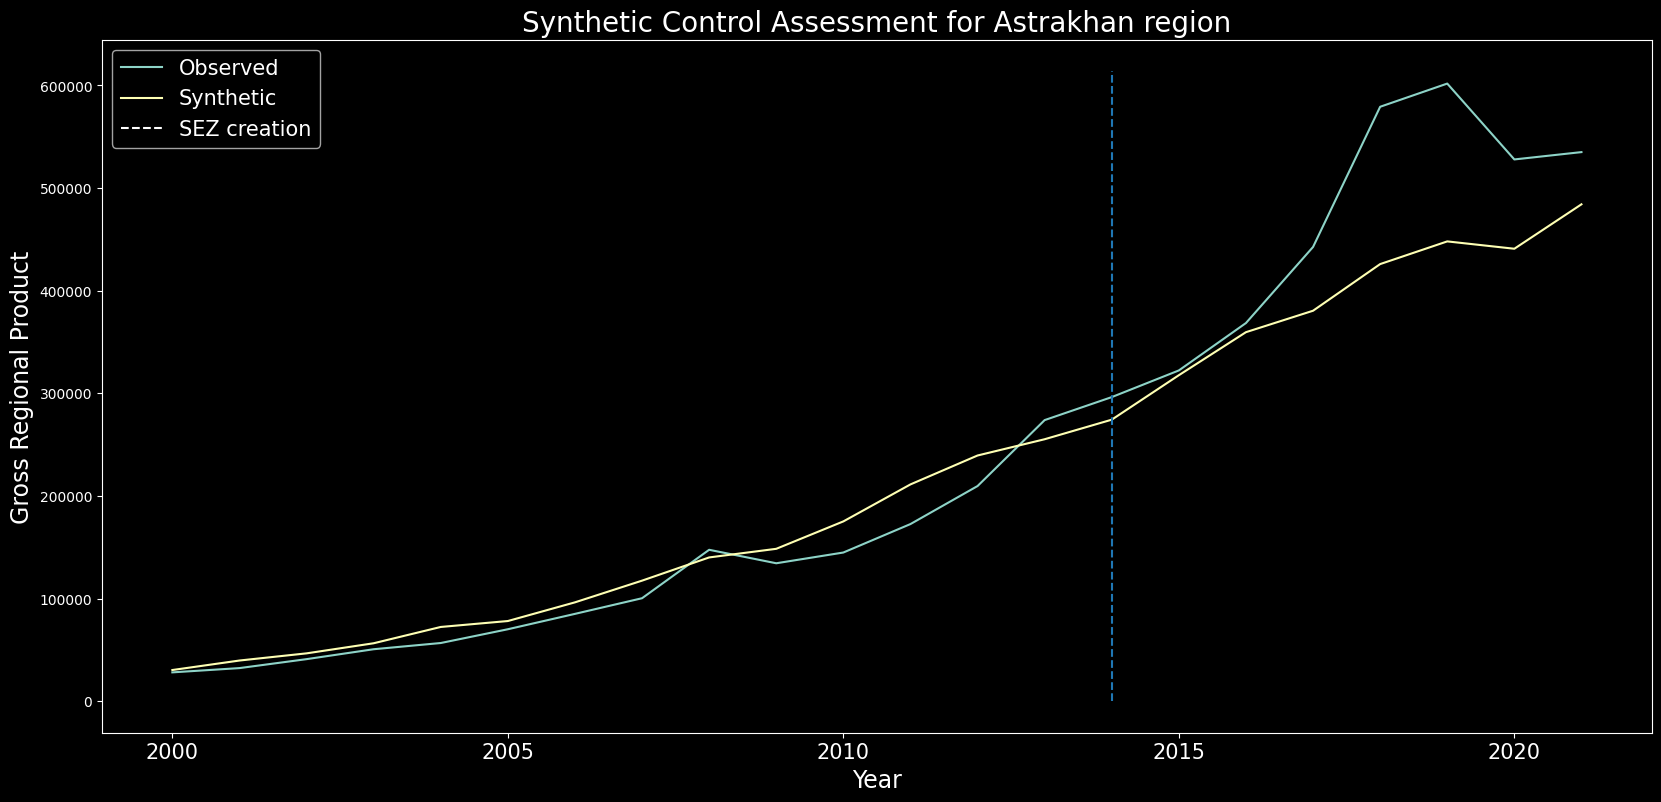

In [13]:
df = synths_for_each_region['astrakhan region']['grp']['res_df']
reigon_annotation = 'Astrakhan region'
variable_annotation = 'Gross Regional Product'
treatment_year = synths_for_each_region['astrakhan region']['treatment_year']
vizualize_synth(df, reigon_annotation, variable_annotation, treatment_year)

In [15]:
df = synths_for_each_region['astrakhan region']['fixed_assets']['res_df']
treatment_year = synths_for_each_region['astrakhan region']['treatment_year']
mae_pre = MAE(df[df['year'] <= treatment_year]['Observed'].values, df[df['year'] <= treatment_year]['Synthetic'].values)
mae_post = MAE(df[df['year'] > treatment_year]['Observed'].values, df[df['year'] > treatment_year]['Synthetic'].values)
pd.DataFrame({
    'Pre': [mae_pre],
    'Post': [mae_post],
    'Post/Pre': [mae_post/mae_pre]
}, index=['MAE'])

,Pre,Post,Post/Pre
MAE,37107.200,212904.792,5.738


In [36]:
synths_for_placebo = {}
for i in range(4):
    current_region = df_grp.index.values[np.random.randint(0, len(df_grp))]
    current_year = 2014
    
    while current_region in LIST_OF_REGIONS_WITH_SEZS:
        current_region = df_grp.index.values[np.random.randint(0, len(df_grp))]


    print(f"Calculating for {current_region}")
    synths_for_placebo[current_region] = calculate_synths_for_placebo(current_region, current_year, LIST_OF_REGIONS_WITH_SEZS, DATAFRAMES)

Calculating for altai region
Calculating for republic of mari el
Calculating for kaliningrad region
Calculating for kemerovo region


In [37]:
post_pre_relations = calculate_post_pre_mae_relations(synths_for_placebo, synths_for_each_region, sezs_region_and_year)

In [38]:
colors = ['cyan' for _ in range(len(post_pre_relations['grp']['x']) - len(list(synths_for_placebo.keys())))]
colors.extend(['green'] * len(list(synths_for_placebo.keys())))

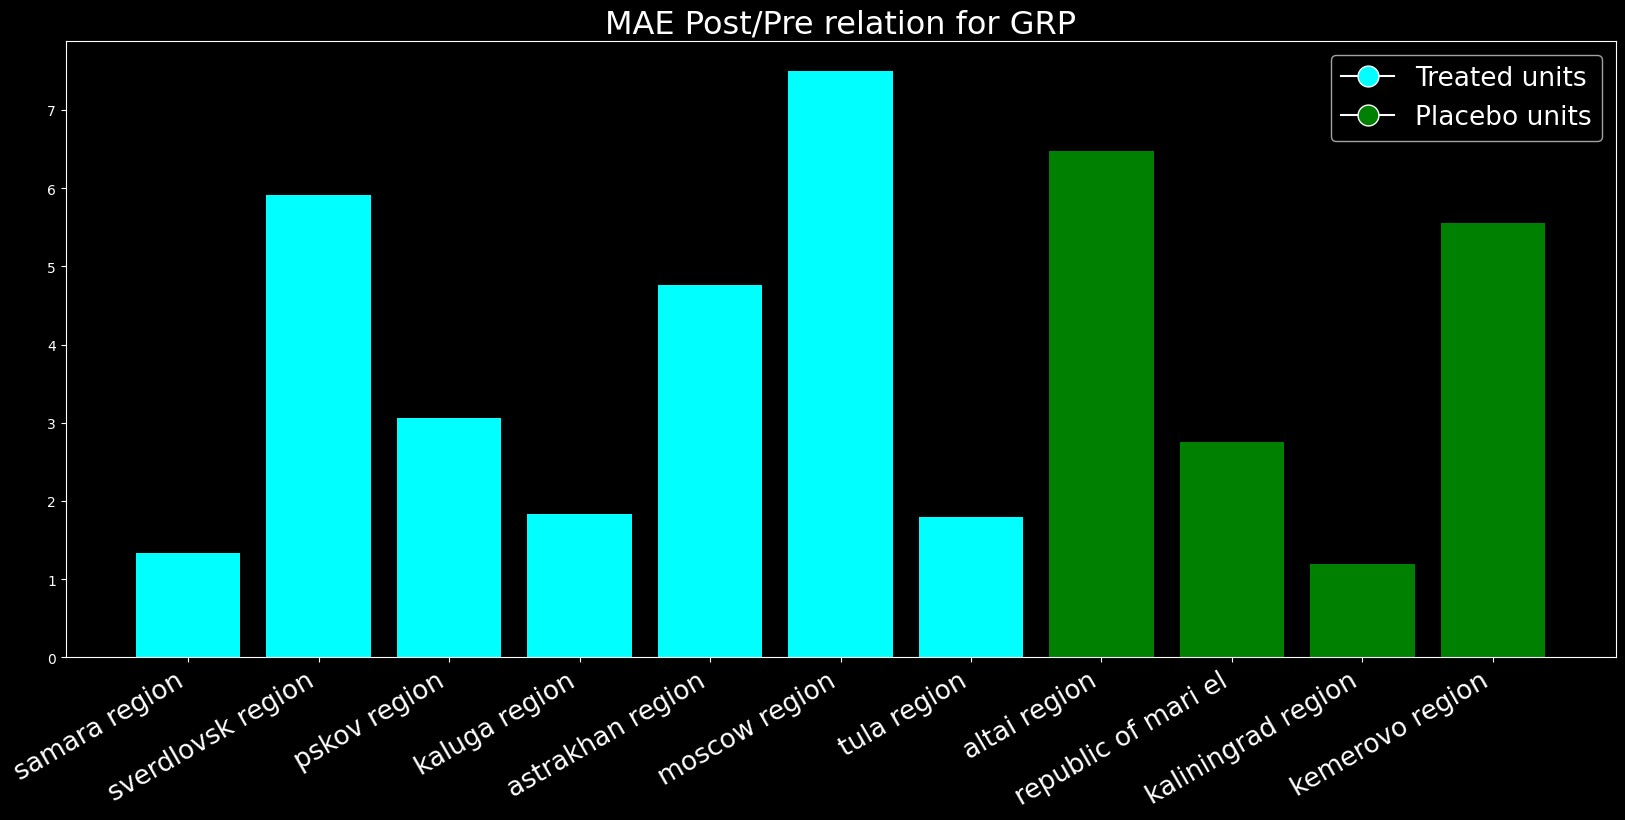

In [39]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 8))
    plt.bar(x=post_pre_relations['grp']['x'], height=post_pre_relations['grp']['height'], color=colors)
    plt.xticks(rotation=30, ha='right', fontsize=19)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Treated units',
                          markerfacecolor='cyan', markersize=15),
                       plt.Line2D([0], [0], marker='o', color='w', label='Placebo units',
                          markerfacecolor='green', markersize=15),
                   ]

    plt.title('MAE Post/Pre relation for GRP', fontsize=23)
    plt.legend(handles=legend_elements, loc='upper right', fontsize=19)

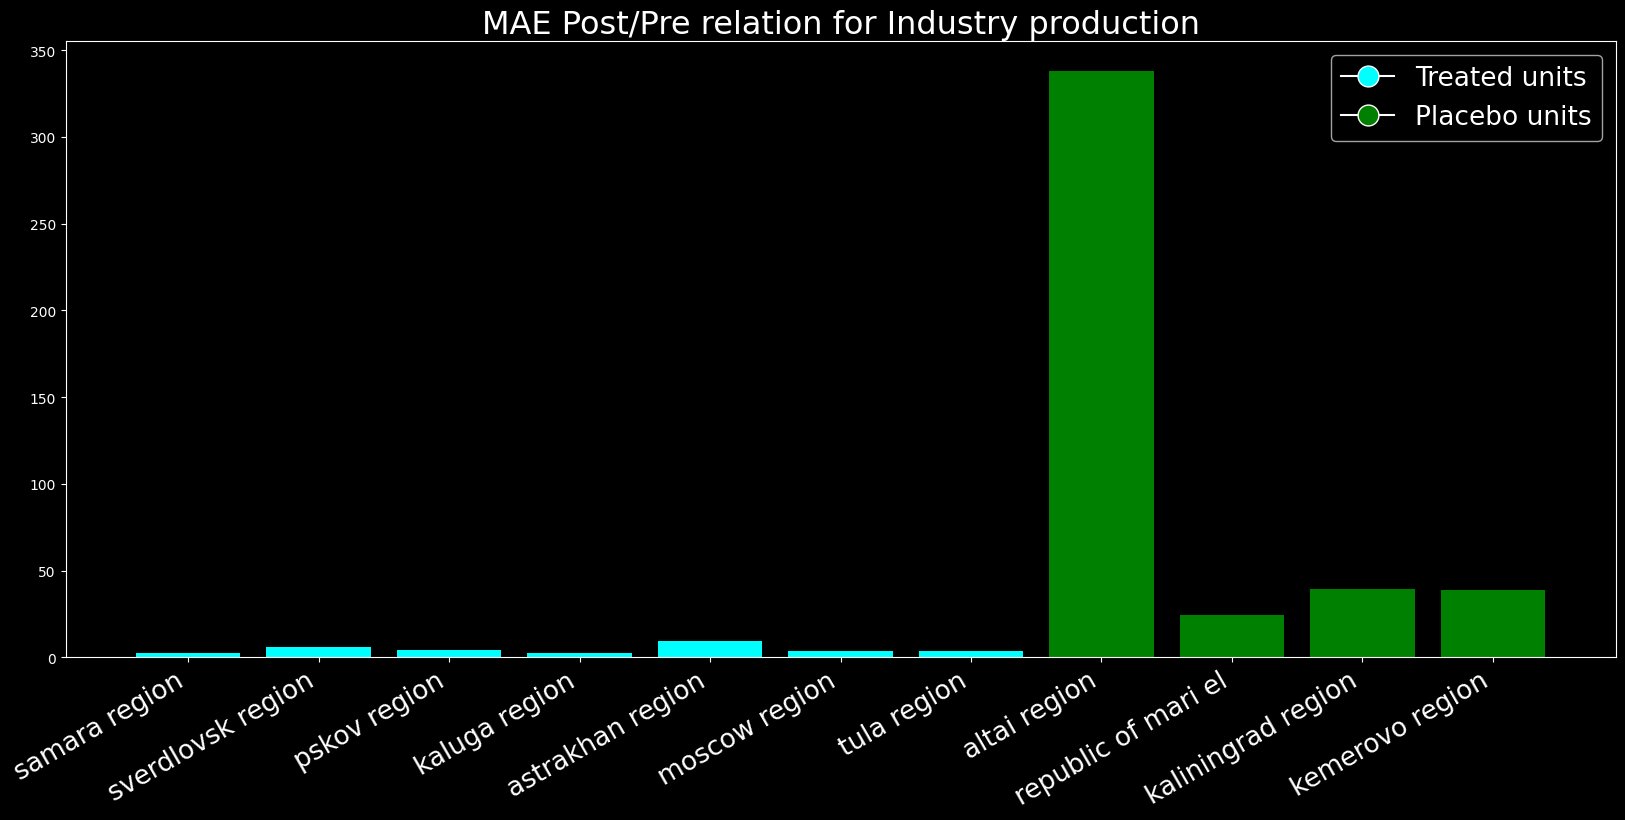

In [40]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 8))
    plt.bar(x=post_pre_relations['grp']['x'], height=post_pre_relations['industry']['height'], color=colors)
    plt.xticks(rotation=30, ha='right', fontsize=19)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Treated units',
                          markerfacecolor='cyan', markersize=15),
                       plt.Line2D([0], [0], marker='o', color='w', label='Placebo units',
                          markerfacecolor='green', markersize=15),
                   ]

    plt.title('MAE Post/Pre relation for Industry production', fontsize=23)
    plt.legend(handles=legend_elements, loc='upper right', fontsize=19)

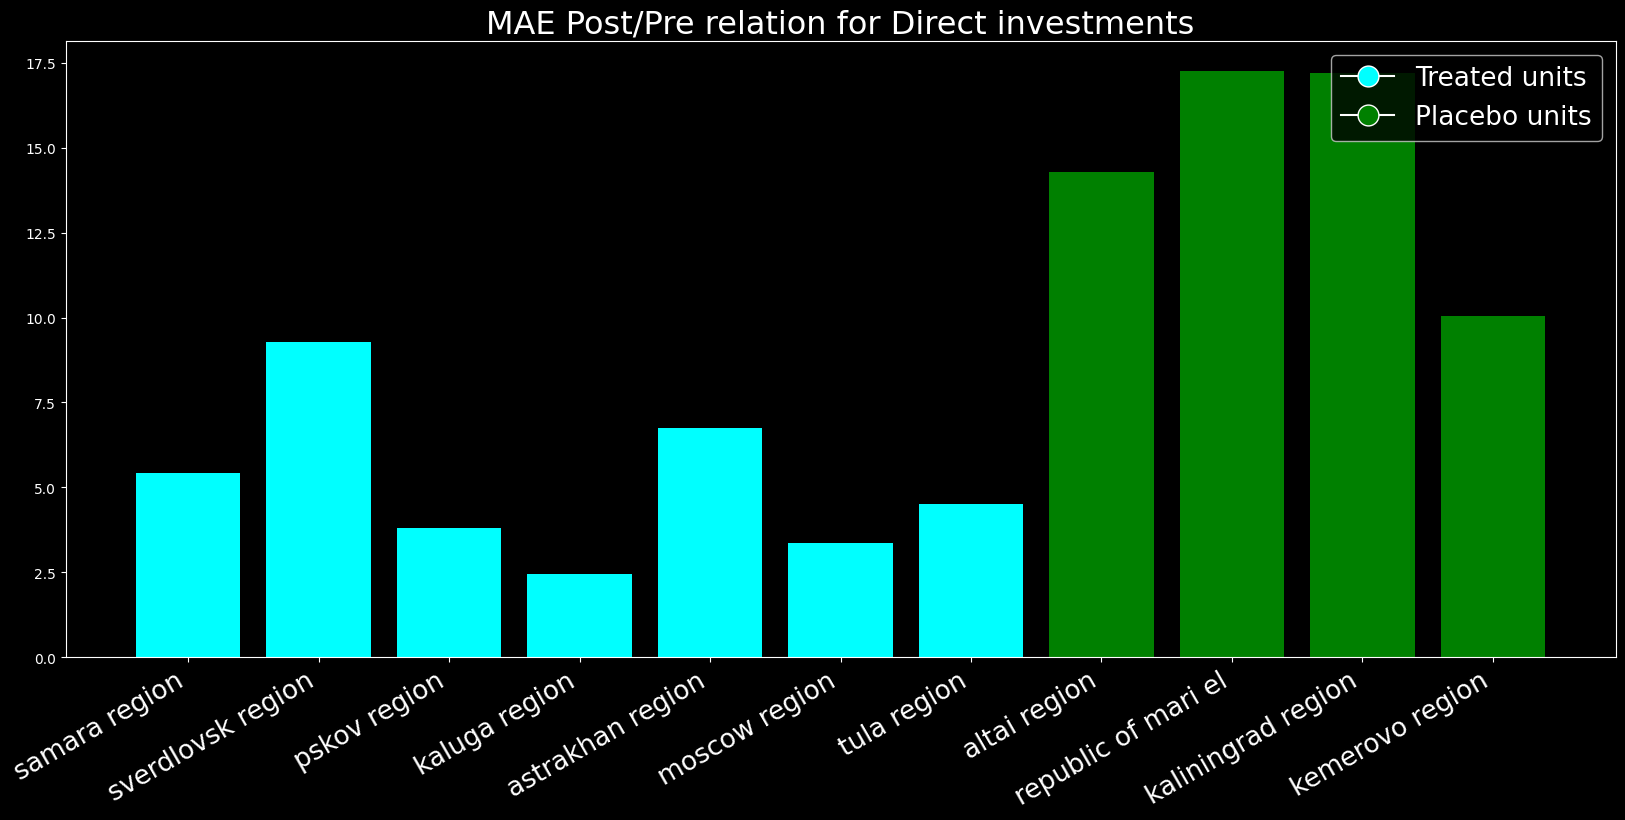

In [41]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 8))
    plt.bar(x=post_pre_relations['grp']['x'], height=post_pre_relations['investments']['height'], color=colors)
    plt.xticks(rotation=30, ha='right', fontsize=19)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Treated units',
                          markerfacecolor='cyan', markersize=15),
                       plt.Line2D([0], [0], marker='o', color='w', label='Placebo units',
                          markerfacecolor='green', markersize=15),
                   ]

    plt.title('MAE Post/Pre relation for Direct investments', fontsize=23)
    plt.legend(handles=legend_elements, loc='upper right', fontsize=19)

In [44]:
filename = 'p_for_russia.txt'
try_calculate_p_values(filename, sezs_region_and_year[2:], synths_for_each_region, DATAFRAMES)

Calculating for ('samara region', 2010)
Unique weights not possible.
Matrix is singular. occured for samara region, grp
Unique weights not possible.
Matrix is singular. occured for samara region, fixed_assets
Calculating for ('sverdlovsk region', 2010)
Unique weights not possible.
Matrix is singular. occured for sverdlovsk region, fixed_assets
Calculating for ('pskov region', 2012)
Unique weights not possible.
Matrix is singular. occured for pskov region, investments
Unique weights not possible.
Matrix is singular. occured for pskov region, fixed_assets
Calculating for ('kaluga region', 2012)
Unique weights not possible.
Matrix is singular. occured for kaluga region, grp
Unique weights not possible.
Matrix is singular. occured for kaluga region, investments
Unique weights not possible.
Matrix is singular. occured for kaluga region, fixed_assets
Calculating for ('astrakhan region', 2014)
Calculating for ('moscow region', 2015)
Calculating for ('tula region', 2016)


In [48]:
result = {'treated': deepcopy(synths_for_each_region), 'placebo': deepcopy(synths_for_placebo)}

In [49]:
for synth_group in result.keys():
    for rname in result[synth_group].keys():
        for variable in result[synth_group][rname].keys():
            if variable != 'treatment_year':
                result[synth_group][rname][variable]['synth'] = {
                    'weights': result[synth_group][rname][variable]['synth'].get_weights(True),
                    'v_matrix': result[synth_group][rname][variable]['synth'].V,
                    'v_pen': result[synth_group][rname][variable]['synth'].fitted_v_pen,
                    'w_pen': result[synth_group][rname][variable]['synth'].fitted_w_pen
                }
                result[synth_group][rname][variable]['res_df'] = result[synth_group][rname][variable]['res_df'].to_dict()

In [50]:
with open("./results/result_ru.json", "w") as outfile:
    json.dump(result, outfile, indent=4, cls=NumpyEncoder)